# Aprendizaje por refuerzo + Ensembles + AutoML

## Objetivos
- Comprender la idea base de **Q-Learning** (RL tabular): estado–acción–recompensa.
- Probar **Ensembles**: `VotingClassifier` y `VotingRegressor`.
- Conocer herramientas de **AutoML** (LazyPredict) y cuándo usarlas.


## Ensembles: Voting, Bagging, Boosting y Stacking

En *ensembles* combinamos **varios modelos** para obtener un modelo conjunto más estable y preciso que cualquiera de ellos por separado.
Cada modelo aprende patrones ligeramente distintos del dataset; al agregarlos, se reducen errores y se mejora la generalización.

### Voting (votación)
- Combina modelos **entrenados en los mismos datos**.
- En clasificación, `VotingClassifier` puede usar:
  - **Hard voting**: cada modelo vota una clase y gana la más votada.
  - **Soft voting**: se promedian las probabilidades (`predict_proba`) y se elige la clase con mayor probabilidad agregada.
- En regresión, `VotingRegressor` promedia las predicciones numéricas.

### Bagging (Bootstrap Aggregating)
- Entrena muchos modelos del mismo tipo sobre **subconjuntos aleatorios** de los datos (con reemplazo).
- La predicción final se hace promediando (regresión) o votando (clasificación).
- Ejemplos: `BaggingClassifier`, `BaggingRegressor`, y las familias `RandomForest*`.

Bagging reduce sobre todo la **varianza** del modelo (ayuda cuando un árbol único sobreajusta).

### Boosting
- Los modelos se entrenan **en serie**: cada modelo nuevo intenta corregir los errores de los anteriores.
- Se combinan las predicciones ponderando más a los modelos que funcionan mejor.
- Ejemplos: `AdaBoostClassifier/Regressor`, `GradientBoostingClassifier/Regressor`.

Boosting suele dar modelos muy potentes, pero es más sensible al ruido y puede sobreajustar si no se controla.

### Stacking (apilamiento)
- Usa **varios modelos base** (por ejemplo: árbol, SVM, regresión logística, etc.).
- Sus predicciones se usan como **nuevas características** para entrenar un **meta-modelo** final.
- En scikit-learn se implementa con `StackingClassifier` y `StackingRegressor`.

Resumen rápido:
- **Voting**: combinación simple de modelos (votación / promedio).
- **Bagging**: muchos modelos del mismo tipo en subconjuntos de datos.
- **Boosting**: modelos en serie que corrigen errores anteriores.
- **Stacking**: combina modelos mediante un meta-modelo entrenado sobre sus salidas.



## 1) Q-Learning en un grafo simple (7 estados)
**Idea:** aprender una política que lleve del estado 0 al estado meta (6) maximizando la recompensa acumulada.


Camino aprendido 0→6: [0, 1, 3, 6]
Q max por estado: [254.64 318.3  318.3  397.88 398.3  497.88 497.35]

Tabla Q redondeada:
[[  0.   254.64 254.64   0.     0.     0.     0.  ]
 [203.71   0.     0.   318.3    0.     0.     0.  ]
 [203.71   0.     0.   318.3    0.     0.     0.  ]
 [  0.   254.64 254.64   0.   318.64   0.   397.88]
 [  0.     0.     0.   318.3    0.   398.3    0.  ]
 [  0.     0.     0.     0.   318.64   0.   497.88]
 [  0.     0.     0.   317.55   0.   398.19 497.35]]


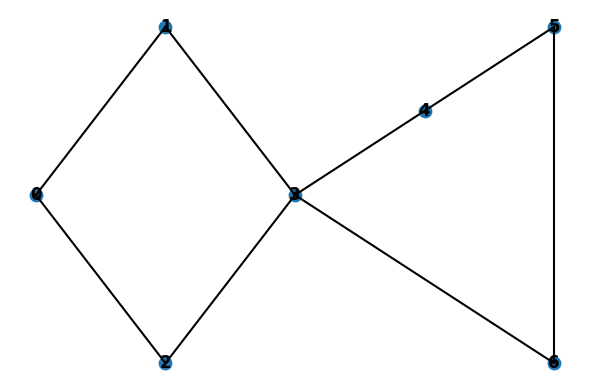

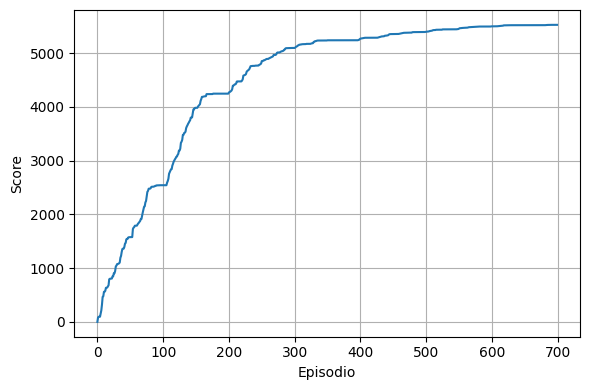

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Definición del grafo y R
# -----------------------------
edges = [(0,1),(0,2),(1,3),(2,3),(3,4),(4,5),(5,6),(3,6)]
N = 7

R = -np.ones((N, N))
for a, b in edges:
    R[a, b] = 0
    R[b, a] = 0
R[5, 6] = 100
R[6, 6] = 100

Q = np.zeros_like(R)
alpha = 0.8
gamma = 0.8

rng = np.random.default_rng(42)

# Para gráfica del proceso de aprendizaje
score_values = []

# -----------------------------
# Entrenamiento Q-Learning
# -----------------------------
for _ in range(700):
    s = rng.integers(0, N)

    while True:
        actions = np.where(R[s] >= 0)[0]
        a = rng.choice(actions)
        ns = a

        Q[s, a] = (1 - alpha) * Q[s, a] + alpha * (R[s, a] + gamma * Q[ns].max())

        s = ns
        if s == 6:
            break

    # score del episodio: suma de la tabla Q
    score_values.append(Q.sum())

# -----------------------------
# Política greedy desde 0
# -----------------------------
path = [0]
s = 0
while s != 6 and len(path) < 20:
    s = int(np.argmax(Q[s]))
    path.append(s)

print("Camino aprendido 0→6:", path)
print("Q max por estado:", np.round(Q.max(axis=1), 2))
print("\nTabla Q redondeada:")
print(np.round(Q, 2))

# -----------------------------
# Gráfico del grafo de estados
# -----------------------------
pos = {
    0: (0.0, 0.0),
    1: (1.0, 1.0),
    2: (1.0,-1.0),
    3: (2.0, 0.0),
    4: (3.0, 0.5),
    5: (4.0, 1.0),
    6: (4.0,-1.0),
}

plt.figure(figsize=(6,4))
for a, b in edges:
    x = [pos[a][0], pos[b][0]]
    y = [pos[a][1], pos[b][1]]
    plt.plot(x, y, "-k")

xs = [pos[i][0] for i in range(N)]
ys = [pos[i][1] for i in range(N)]
plt.scatter(xs, ys, s=80)

for i in range(N):
    plt.text(pos[i][0], pos[i][1], str(i), ha="center", va="center",
             fontsize=12, fontweight="bold")

plt.axis("off")
plt.tight_layout()
plt.show()

# -----------------------------
# Gráfico del proceso de aprendizaje
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(score_values)
plt.xlabel("Episodio")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()


## 2) Ensembles: **VotingClassifier** en Iris

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

X, y = load_iris(return_X_y=True)

clf1 = LogisticRegression(max_iter=2000, random_state=42)
clf2 = RandomForestClassifier(n_estimators=150, random_state=42)
clf3 = GaussianNB()
clf4 = SVC(probability=True, random_state=42)

vclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('svc', clf4)],
    voting='soft'
)

modelos = {
    'LogisticRegression': clf1,
    'RandomForest': clf2,
    'GaussianNB': clf3,
    'SVC': clf4,
    'Voting (ensemble)': vclf,
}

for nombre, modelo in modelos.items():
    scores = cross_val_score(modelo, X, y, cv=5, scoring='accuracy')
    print(f"{nombre} accuracy (cv=5): {scores.mean():.4f} +/- {scores.std():.4f}")


LogisticRegression accuracy (cv=5): 0.9733 +/- 0.0249
RandomForest accuracy (cv=5): 0.9667 +/- 0.0211
GaussianNB accuracy (cv=5): 0.9533 +/- 0.0267
SVC accuracy (cv=5): 0.9667 +/- 0.0211
Voting (ensemble) accuracy (cv=5): 0.9600 +/- 0.0249


## 3) Ensembles: **VotingRegressor** en Diabetes

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score

X, y = load_diabetes(return_X_y=True)
reg1 = GradientBoostingRegressor(random_state=42)
reg2 = RandomForestRegressor(random_state=42)
reg3 = LinearRegression()

vreg = VotingRegressor([('gbr', reg1), ('rfr', reg2), ('lr', reg3)])

modelos = {
    'GradientBoostingRegressor': reg1,
    'RandomForestRegressor': reg2,
    'LinearRegression': reg3,
    'VotingRegressor (ensemble)': vreg,
}

scorer = make_scorer(r2_score)
for nombre, modelo in modelos.items():
    r2 = cross_val_score(modelo, X, y, cv=5, scoring=scorer)
    print(f"{nombre} R² (cv=5): {r2.mean():.4f} +/- {r2.std():.4f}")


VotingRegressor R² (cv=5): 0.4645 +/- 0.0522


## 4) AutoML (visión general rápida)
- **LazyPredict**: genera y evalúa una colección de modelos con parámetros por defecto (rápido para obtener un *baseline* y comparar modelos). [LazyPredict](https://github.com/shankarpandala/lazypredict)


In [ ]:
# --- LazyPredict (Clasificación) ---
!pip install lazypredict --quiet

import io, contextlib, warnings
warnings.filterwarnings("ignore")

from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import all_estimators

# ---- 1) Datos: usa X,y si ya existen; si no, cae a Iris ----
try:
    X, y
except NameError:
    from sklearn.datasets import load_iris
    data = load_iris()
    X, y = data.data, data.target

# ---- 2) Split + LazyPredict con salida silenciada ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf = LazyClassifier(verbose=0, ignore_warnings=True)

with contextlib.redirect_stdout(io.StringIO()):
    models, preds = clf.fit(X_train, X_test, y_train, y_test)

print("Ranking de modelos (top 10):")
display(models.head(10))

# ---- 3) Validación cruzada del top-3 por Accuracy ----
# Tomamos los nombres de los 3 primeros
top3_names = models.index[:3].tolist()

# Mapeamos nombres -> clases sklearn disponibles
sk_clfs = {name: cls for name, cls in all_estimators(type_filter='classifier')}

print("\nValidación cruzada (5-fold) del top-3:")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name in top3_names:
    if name in sk_clfs:
        try:
            Est = sk_clfs[name]
            # Pipeline con StandardScaler por si el modelo es sensible a escalado
            pipe = make_pipeline(StandardScaler(with_mean=hasattr(X, "shape")), Est())
            scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
            print(f"- {name:30s} accuracy = {scores.mean():.4f} ± {scores.std():.4f}")
        except Exception as e:
            print(f"- {name:30s} (no evaluado) -> {e.__class__.__name__}: {e}")
    else:
        print(f"- {name:30s} no está en sklearn.utils.all_estimators()")


  0%|          | 0/29 [00:00<?, ?it/s]

Ranking de modelos (top 10):


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
QuadraticDiscriminantAnalysis,1.00,1.00,None,1.00,0.01
LinearDiscriminantAnalysis,1.00,1.00,None,1.00,0.01
LabelSpreading,0.95,0.95,None,0.95,0.01
SVC,0.95,0.95,None,0.95,0.01
ExtraTreeClassifier,0.95,0.95,None,0.95,0.01
ExtraTreesClassifier,0.95,0.95,None,0.95,0.11
LabelPropagation,0.95,0.95,None,0.95,0.01
GaussianNB,0.92,0.92,None,0.92,0.02
RandomForestClassifier,0.92,0.92,None,0.92,0.15



Validación cruzada (5-fold) del top-3:
- QuadraticDiscriminantAnalysis  accuracy = 0.9800 ± 0.0267
- LinearDiscriminantAnalysis     accuracy = 0.9733 ± 0.0389
- LabelSpreading                 accuracy = 0.9400 ± 0.0533


## Ejercicios finales

### 1. Q-Learning: parámetros y convergencia
- Cambia `gamma` (0.4, 0.7, 0.9) y nº de episodios (200–1000).
- Dibuja la **curva de recompensa** (recompensa total por episodio).
- Compara la **velocidad de convergencia**.

**Curva de recompensa:** muestra la recompensa total obtenida en cada episodio.
**Velocidad de convergencia:** cuántos episodios tarda en estabilizarse el aprendizaje.

### 2. VotingClassifier: análisis de modelos
- Prueba conjuntos de modelos distintos (más parecidos vs más heterogéneos).
- Compara accuracy individual vs ensemble (CV=5) y comenta cuándo mejora el conjunto.

### 3. VotingRegressor: distintos pesos
- Prueba pesos como `[1,1,1]`, `[3,1,1]`, `[1,3,1]`.
- Evalúa R² y analiza si mejora priorizar el modelo más fuerte o no.

### 4. LazyPredict: comparación rápida
- Ejecuta LazyPredict sobre un dataset.
- Reflexiona: ¿qué modelos destacan y por qué?

### 5. Debate breve: AutoML en DAW
- ¿Cuándo es útil AutoML para un desarrollador web?
- ¿Qué riesgos tiene usarlo sin entender bien los modelos?
